In [1]:
# Initialising and loading some packages 
%matplotlib notebook
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.modeling.fitting import LevMarLSQFitter
import matplotlib.pyplot as plt
from photutils.isophote import EllipseGeometry, build_ellipse_model, Ellipse
import acstools

plt.rcParams['font.family']='serif'

# Pimp up jupuyter
#import jupyterthemes as jt
#from jupyterthemes.stylefx import set_nb_theme

# uncomment and execute line to try a new theme
#jt.get_themes()
#set_nb_theme('onedork')
#set_nb_theme('chesterish')
#set_nb_theme('grade3')
#set_nb_theme('oceans16')
#set_nb_theme('solarizedl')
#set_nb_theme('solarizedd')
#set_nb_theme('monokai')


The following tasks in the acstools package can be run with TEAL:
          acs2d                  acs_destripe           acs_destripe_plus     
          acsccd                    acscte              acscteforwardmodel    
          acsrej                    acssum                    calacs
PixCteCorr is no longer supported. Please use acscte.


In [2]:
# Getting image data and printing some basics 

# NGC3521
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_09042_45_wfpc2_f814w_wf&filename=hst_09042_45_wfpc2_f814w_wf_drz.fits'
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_09042_45_wfpc2_f814w_wf&filename=hst_09042_45_wfpc2_f450w_wf_drz.fits'
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_11128_18_wfpc2_f336w_wf&filename=hst_11128_18_wfpc2_f336w_pc_drz.fits'
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_05446_1f_wfpc2_total_wf&filename=hst_05446_1f_wfpc2_f606w_pc_drz.fits'

# NGC3379
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_11679_06_acs_wfc_f850lp&filename=hst_11679_06_acs_wfc_f475w_drz.fits'
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_11679_06_acs_wfc_f850lp&filename=hst_11679_06_acs_wfc_f850lp_drz.fits'

# NGC5128, CenA
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_11360_ra_wfc3_ir_f160w&filename=hst_11360_ra_wfc3_ir_f160w_drz.fits'

# M81
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_9788_18_acs_wfc_f814w&filename=hst_9788_18_acs_wfc_f814w_drz.fits'
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_11421_01_wfc3_ir_f110w&filename=hst_11421_01_wfc3_ir_f110w_drz.fits'

# dw1335-29 M81 outer 
url='http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_10608_04_acs_sbc_f150lp&filename=hst_10608_04_acs_sbc_f150lp_drz.fits'

# Use the image faile name as a root name for the files to be saved
if '/' in url: filename = url[url.rfind('/')+1:url.rfind('.fits')]
if 'http' in url and 'hst_' in url: filename = url[url.rfind('=')+1:url.rfind('.fits')]

if 'data' in locals() or 'data' in globals(): del data,data_hdr,wcs

hdu = fits.open(url)
wcs = WCS(hdu[1].header)
data = hdu[1].data #fits.getdata(url) # 
data_hdr = fits.getheader(url) # hdu[0].header # 
    
# Create a mask
data = np.ma.masked_equal(data,-0.)
data = np.ma.masked_invalid(data)

print('min={:.2f}, max={:.2f}, EXPTIME={:.2f}\
'.format(data.min(),data.max(),data_hdr['EXPTIME']))
data_hdr.get('*object*'),data_hdr.get('*date*'),data_hdr.get('*instr*'),data_hdr.get('*detect*'),\
data_hdr.get('*scal*'),data_hdr.get('*gai*'),data_hdr.get('*readn*'),data_hdr.get('*sky*'),\
data_hdr.get('*filt*'),data_hdr.get('*targ*'),data_hdr.get('*combi*'),data_hdr.get('*uni*')

min=0.00, max=0.08, EXPTIME=5416.00


(,
 DATE-OBS= '2005-12-29'         / UT date of start of observation (yyyy-mm-dd)   
 DATE    = '2017-10-20'                                                          ,
 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data ,
 DETECTOR= 'SBC'                / detector in use: WFC, HRC, or SBC              ,
 D001SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D002SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D003SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D004SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D005SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D006SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D007SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   
 D008SCAL=                 0.03 / Drizzle, pixel size (arcsec) of output image   ,
 ,
 ,
 ,


In [3]:
# ONLY FOR ACS & WFC3 HLA products!!! Convert from electrons/sec to data counts. Execute ONCE per data read 

exptime = data_hdr['EXPTIME']

data = data * exptime / float(input('WARNING! Divide the exptime by the number of combined frames: 1.') or 1.)
print('min={:.2f}, max={:.2f}'.format(data.min(),data.max()))

WARNING! Divide the exptime by the number of combined frames: 1.8
min=0.00, max=51.38


In [4]:
# Obtaining ACS zeropoint for specific date and filter 
for iter_filter in [data_hdr['FILTER1'],data_hdr['FILTER2']]:
    if iter_filter!='N/A':
        q = acstools.acszpt.Query(date=data_hdr['DATE'],detector=data_hdr['DETECTOR'],\
                                  filt=iter_filter)
        zpt_table = q.fetch()
        print(zpt_table)

INFO:acszpt.Query:Checking inputs...
INFO:acszpt.Query:Submitting request to https://acszeropoints.stsci.edu/results_single/?date1=2017-10-20&detector=SBC&SBC_filter=F150LP
INFO:acszpt.Query:Parsing the response and formatting the results...


FILTER PHOTPLAM        PHOTFLAM         STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom cm2 s) mag(ST)   mag   mag(AB)
------ -------- ---------------------- ------- ------- -------
F150LP   1606.0              3.593e-17  20.011  20.675  22.675


In [5]:
# Set some other data constants: filter, pixscale, ZP, distance 

#filters = data_hdr['FILTER']
target = 'dw1335_29' #data_hdr['TARGNAME'] #'NGC5128' #
exptime = data_hdr['EXPTIME']
skyval = 0.0 #data_hdr['MDRIZSKY'] #SKYVAL']
gain = 1 #data_hdr['CCDGAIN'] #ATODGAIN'] #
pix_to_asec = data_hdr['D001SCAL'] #0.09 #PIXSCALE']

if data_hdr["INSTRUME"]=='ACS':
    for iter_filter in [data_hdr['FILTER1'],data_hdr['FILTER2']]:
        if iter_filter!='N/A':
            filters=zpt_table['FILTER'][0]
            ZP = zpt_table['VEGAmag'].value[0]
else:
    filters='SBC_F150LP'
    ZP_cpe = {'F438W':26.0628, 'F555W': 25.257,\
              'WFPC2_PC_F336W':19.429,'WFC_F475W':26.153,'WFPC2_WF_F450W':21.982,\
              'WFPC2_PC_F606W':22.850, 'WFC_F606W':25.734,\
              'WFC_F814W':25.530,'WFPC2_WF_F814W':21.625,\
              'HRC_F555W':25.257,\
              'WFC3_F110W':24.991,'SBC_F150LP':20.675, 'WFC3_F160W':24.6949,\
              'WFC_F850LP':24.336,\
              'LBT_Ks':25.259}
    ZP = ZP_cpe[filters]

ZP = ZP #+2.5*np.log10(gain)
mM = 28.499 # dw1335_29 27.78 # M81 27.817 # NGC5128 30.25 # NGC3521 ; 30.14 # NGC3379
D = 10**(.2*(mM+5))

print('Target: {:s}, Filter={:s}, ZP={:.3f}, pixscale={:.3f}, mM={:.2f}, D={:.2f}Mpc'\
      .format(target,filters,ZP,pix_to_asec,mM,D*1.e-6))

Target: dw1335_29, Filter=F150LP, ZP=20.675, pixscale=0.030, mM=28.50, D=5.01Mpc


<IPython.core.display.Javascript object>


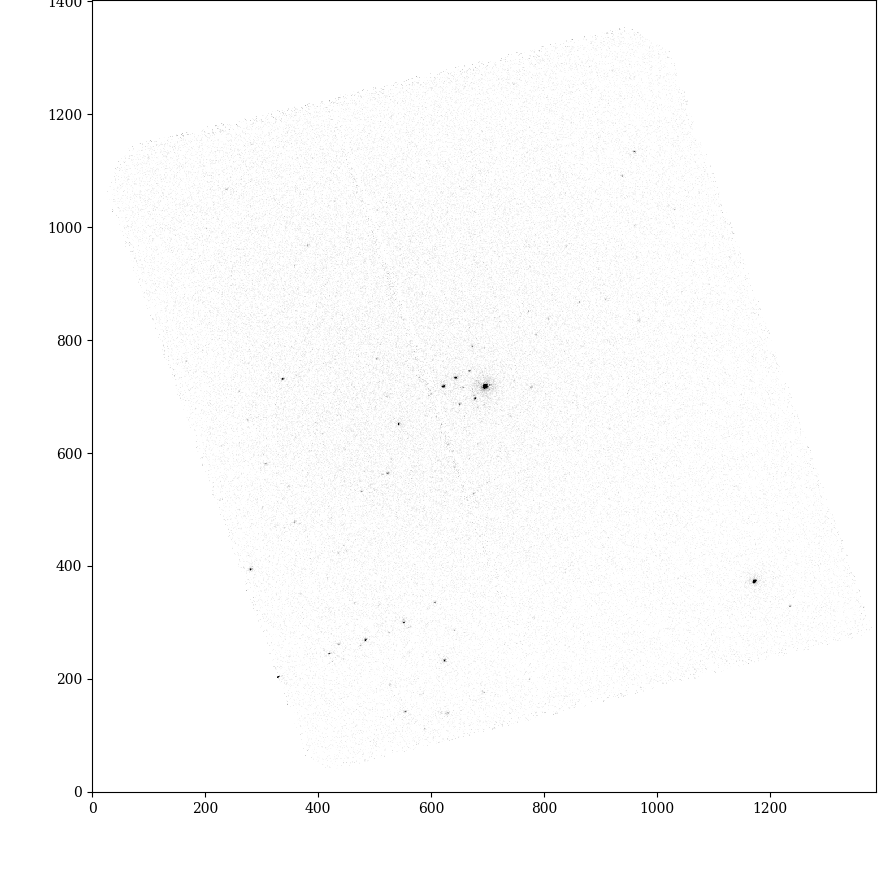

In [6]:
# Quick visualisation to pick a target center. You can use the WCS projection if needed
plt.close(1)
fig = plt.figure(1,figsize=(8.8,8.8))
ax1 = fig.add_subplot(1,1,1,position=[.1,.1,.9,.9]) #,projection=wcs)

ax1.imshow(data,origin='lower',vmin=data.min(),vmax=data.max()*.05,cmap='gray_r')

In [7]:
# Setting initial guess for the coordinates 

# Some clean up first. This is to avoid to proceede with some preexisting values if something goes wrong 
if 'g' in locals() or 'g' in globals(): del g

# NGC3521
# F814W
g = EllipseGeometry(1041.5,970.5, 25., 0.1, 45./180.*np.pi)
# F450W
g = EllipseGeometry(1041.5,970.5, 15., 0.1, 45./180.*np.pi)
# F336W
g = EllipseGeometry(572.5,463.5, 15., 0.1, 45./180.*np.pi)
# F606W
g = EllipseGeometry(493.5,214.5, 15., 0.1, 45./180.*np.pi)
# NGC3379
g = EllipseGeometry(3312.5,5615.5, 11., 0.1, 45./180.*np.pi)
# NGC5128
g = EllipseGeometry(535.5,564.5, 5., 0.1, 45./180.*np.pi)
# NGC3031
# F814W
g = EllipseGeometry(x0=3367.5,y0=3806.5, sma=5., eps=0.1, pa=45./180.*np.pi)
# F110W
g = EllipseGeometry(x0=867.5,y0=974.5, sma=5., eps=0.1, pa=45./180.*np.pi)
# dw1335_29 F150LP
# GC1
g = EllipseGeometry(x0=620.5,y0=718.5, sma=5., eps=0.1, pa=45./180.*np.pi)
# NSC
g = EllipseGeometry(x0=694.5,y0=717.5, sma=5., eps=0.1, pa=45./180.*np.pi)


In [8]:
# Initializing the geometry of an ellipse, finding its center and assigning it to xcen,ycen 

if 'ellipse' in locals() or 'ellipse' in globals(): del ellipse
g.find_center(data); xcen,ycen = int(g.x0), int(g.y0)
ellipse = Ellipse(data,geometry=g,threshold=0.0)


INFO:astropy:Found center at x0 = 695.0, y0 = 719.0


INFO: Found center at x0 = 695.0, y0 = 719.0 [photutils.isophote.geometry]


In [ ]:
# (Optional) To speed up calculations, analyse a box centered around the target 

# Box width around the target of interest
dx = 60; dy = 60

# Removing the mask increases speed. But chose no if mask is a must to have
if (input('WARNING! Do you want to erase the mask to speed up things? [Yes/no]: Yes') or 'Yes')=='Yes':
    data = np.ma.getdata(data)
    print('Mask deleted')

x1 = int(g.x0 - dx/2.) ; x2 = int(g.x0 + dx/2.) ; y1 = int(g.y0 - dy/2.) ; y2 = int(g.y0 + dy/2.)
if x1 < 0 : x1 = 0
if x2 > data.shape[0] : x2 = data.shape[0] 
if y1 < 0 : y1 = 0
if y2 > data.shape[1] : y2 = data.shape[1]

data = data[y1:y2,x1:x2]
g = EllipseGeometry(x0=dx/.2, y0=dy/2., sma=15., eps=0.1, pa=45./180.*np.pi)

if 'ellipse' in locals() or 'ellipse' in globals(): del ellipse
g.find_center(data); xcen,ycen = int(dx/.2), int(dy/2.)
ellipse = Ellipse(data,geometry=g,threshold=0.0)


In [9]:
# Running ellipse. This may require some experiemntation with fit_image parameters 
!date
print('ellipse is running ... ', end=' ')
if 'isolist' in locals() or 'isolist' in globals(): del isolist
isolist = ellipse.fit_image(sma0=3,maxsma=500,maxgerr=2.5,minit=50,maxit=100, integrmode='median') #, maxgerr=1.5, fflag=0.9) #) #,
print('')
!date

Wed Aug 21 14:39:04 CEST 2019
ellipse is running ...  
Wed Aug 21 14:40:21 CEST 2019


In [ ]:
# (Optional) Fit the central peak (if minsma=0.5 above) and add it to the isophote list 
from photutils.isophote.sample import CentralEllipseSample
from photutils.isophote.fitter import CentralEllipseFitter

# central peak position adopted from the previous fit
g_cen = EllipseGeometry(g.x0, g.y0, 0.0, 0., 0.)
g_cen.find_center(data)
print(data,g,g_cen)

# then we build a CentralEllipseSample instance and call the 
# CentralEllipseFitter on it.
sample = CentralEllipseSample(data, 0., geometry=g_cen)
fitter = CentralEllipseFitter(sample)
center = fitter.fit()

isolist.append(center)
isolist.sort()

In [10]:
# Writing to a file the ellipse result 
isolist_tbl = isolist.to_table()
isolist_tbl.write('{:s}_{:s}_x{:s}_y{:s}_pyell.dat'\
                  .format(target,filename,str(g.x0),str(g.y0)),\
                  overwrite=True,\
                  format='ascii.ecsv') #, formats={'sma' : '.3f', 'intens' : '.3f', 'intens_err' : '.3f', \
#                                            'ellipticity' : '.3f', 'ellipticity_err' : '.3f', 'pa' : '.3f', \
#                                            'pa_err' : '.3f', 'grad_rerr' : '.3f'})

print('ellipse fit saved to:\n{:s}_{:s}_x{:s}_y{:s}_pyell.dat'\
      .format(target,filename,str(g.x0),str(g.y0)))

ellipse fit saved to:
dw1335_29_hst_10608_04_acs_sbc_f150lp_drz_x695.0_y719.0_pyell.dat


In [11]:
# Make a model image from ellipse 
!date
print('build_ellipse_model is running ... ', end=' ')
model_image = build_ellipse_model(data.shape, isolist, fill=skyval)
print('')
!date

print('Saving ellipse model saved to:\n{:s}_{:s}_x{:s}_y{:s}_pyell.fits'\
      .format(target,filename,str(g.x0),str(g.y0)))
fits.writeto('{:s}_{:s}_x{:s}_y{:s}_pyell.fits.gz'.format(target,filename,str(g.x0),str(g.y0)),\
            model_image,header=data_hdr,overwrite=True)


Wed Aug 21 14:40:22 CEST 2019
build_ellipse_model is running ...  
Wed Aug 21 14:42:47 CEST 2019
Saving ellipse model saved to:
dw1335_29_hst_10608_04_acs_sbc_f150lp_drz_x695.0_y719.0_pyell.fits


<IPython.core.display.Javascript object>


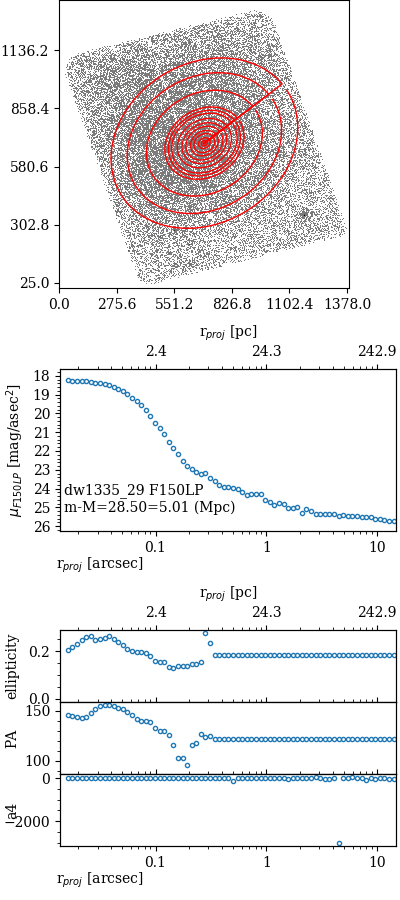

[]

In [12]:
# Visualizing the Ellipse SB photometry 

pix_to_pc = D * (np.pi/180)*(pix_to_asec/3600.)
dry=int(data.shape[1]/2.); drx=int(data.shape[0]/2.)

plt.close(2)
plt.rcParams['font.family']='serif'
plt.rcParams['xtick.top'] = True; plt.rcParams['xtick.labeltop']=False
column=1
fig2 = plt.figure(2,figsize=(4*column,9))

f2_ax1 = fig2.add_axes([.06,.68,.9/column,.32])
f2_ax2 = fig2.add_axes([.15,.41,.84/column,.18])
f2_ax3 = fig2.add_axes([.15,.22,.84/column,.08])
f2_ax4 = fig2.add_axes([.15,.14,.84/column,.08])
f2_ax5 = fig2.add_axes([.15,.06,.84/column,.08])

for subaxes in [f2_ax2,f2_ax3,f2_ax4,f2_ax5]:
    subaxes.set_xscale('log')
    subaxes.set_xticks((0.1,1,10,100))
    subaxes.set_xlim(isolist.sma[1]*.85*pix_to_asec,isolist.sma.max()*1.05*pix_to_asec)
    subaxes.set_xticklabels(['{:.1f}'.format(0.1),\
                             '{:.0f}'.format(1),\
                             '{:.0f}'.format(10),\
                             '{:.0f}'.format(100)])
    subaxes.minorticks_on()

f2_ax2T,f2_ax3T,f2_ax4T,f2_ax5T = f2_ax2.twiny(),f2_ax3.twiny(),f2_ax4.twiny(),f2_ax5.twiny()
for subaxesT in [f2_ax2T,f2_ax3T,f2_ax4T,f2_ax5T]:
    subaxesT.set_xscale('log')
    subaxesT.set_xticks((0.1,1,10,100))
    subaxesT.set_xlim(isolist.sma[1]*.85*pix_to_asec,isolist.sma.max()*1.05*pix_to_asec)
    subaxesT.set_xticklabels(['{:.1f}'.format(0.1*pix_to_pc/pix_to_asec),\
                             '{:.1f}'.format(1*pix_to_pc/pix_to_asec),\
                             '{:.1f}'.format(10*pix_to_pc/pix_to_asec),\
                             '{:.1f}'.format(100*pix_to_pc/pix_to_asec)])

y1=int(g.y0-dry) ; y2=int(g.y0+dry);x1=int(g.x0-drx) ; x2=int(g.x0+drx)
if y1<0 : y1=0
if x1<0 : x1=0

# If plot_residual=False plots the original image. 
# If plot_residual=True Checks if model image exists. If not, plots the original image
plot_residual=True
if plot_residual==True:
    if 'model_image' in locals() or 'model_image' in globals():
        rsd = data-model_image
        f2_ax1.imshow(rsd[y1:y2,x1:x2],origin='lower',\
                      vmin=rsd[y1:y2,x1:x2].min(),vmax=rsd[y1:y2,x1:x2].mean()*100,cmap='gray_r')
    else:
        rsd = data
        f2_ax1.imshow(rsd[y1:y2,x1:x2],origin='lower',\
                      vmin=rsd[y1:y2,x1:x2].min(),vmax=rsd[y1:y2,x1:x2].mean()*0.3,cmap='gray_r')
else:
    rsd = data
    f2_ax1.imshow(rsd[y1:y2,x1:x2],origin='lower',\
                  vmin=rsd[y1:y2,x1:x2].min(),vmax=rsd[y1:y2,x1:x2].mean()*5,cmap='gray_r')



#f2_ax1.imshow(rsd[y1:y2,x1:x2],origin='lower',\
#              vmin=-10,vmax=rsd[y1:y2,x1:x2].mean()*0.3,cmap='gray_r')
#f2_ax1.set_xlim(0,rsd[y1:y2,x1:x2].shape[0])
#f2_ax1.set_ylim(0,rsd[y1:y2,x1:x2].shape[1])
xticks = np.arange(x1,x2,rsd[y1:y2,x1:x2].shape[0]/5)
xtickla = ['%1.1f' % xtick for xtick in xticks]
yticks = np.arange(y1,y2,rsd[y1:y2,x1:x2].shape[1]/5)
ytickla = ['%1.1f' % ytick for ytick in yticks]
f2_ax1.set_xticks(xticks)
f2_ax1.set_xticklabels(xtickla)
f2_ax1.set_yticks(yticks)
f2_ax1.set_yticklabels(ytickla)

isos = []
for sma in [5., 15., 30.,50,70,90,110,140,160,180,200,300,400,500]:
    iso = isolist.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    f2_ax1.plot(x-x1, y-y1, color='r',lw=1)

SB_mag = -2.5*np.log10((isolist.intens-skyval)/exptime) + ZP + 2.5*np.log10(pix_to_asec**2)

#i_ell = np.genfromtxt('SB/G1_20161019_L1_reg_ccdclip_1038.74_1069.03.dat',comments='#',missing_values='INDEF').T
#f2_ax2.yaxis.set_visible(False)
f2_ax2.set_ylabel(r'$\mu_{{{:s}}}$ [mag/asec$^2$]'.format(filters))
f2_ax2.set_xlabel('r$_{proj}$ [arcsec]')
f2_ax2.xaxis.set_label_coords(4*pix_to_asec,-0.15)
f2_ax2.annotate('{:s} {:s}\nm-M={:.2f}={:.2f} (Mpc)'\
                .format(target,filters,mM,D*1.e-6),\
                xy=(.5*pix_to_asec,SB_mag.max()*.98))
f2_ax2T.set_xlabel('r$_{proj}$ [pc]')
f2_ax2T.xaxis.set_label_coords(.5,1.2)
f2_ax2.plot(isolist.sma*pix_to_asec,SB_mag,'o',ms=3,fillstyle='none')
f2_ax2.set_yticks(np.arange(0,35,1))
f2_ax2.set_ylim(1.02*np.nanmax(SB_mag),.97*np.nanmin(SB_mag))
f2_ax2.yaxis.set_label_coords(-.1,.5)

f2_ax3.set_ylabel('ellipticity')
f2_ax3.yaxis.set_label_coords(-.12,.5)
f2_ax3.plot(isolist.sma*pix_to_asec,isolist.eps,'o',ms=3,fillstyle='none')
f2_ax3.set_xticklabels('')
f2_ax3T.set_xlabel('r$_{proj}$ [pc]')
f2_ax3T.xaxis.set_label_coords(0.5,1.45)

f2_ax4.set_ylabel('PA')
f2_ax4.yaxis.set_label_coords(-.12,.5)
f2_ax4.plot(isolist.sma*pix_to_asec,90+isolist.pa*180/np.pi,'o',ms=3,fillstyle='none')
f2_ax4.set_xticklabels(''); f2_ax4T.set_xticklabels('')

f2_ax5.set_ylabel('a4')
f2_ax5.yaxis.set_label_coords(-.12,.5)
f2_ax5.set_xlabel('r$_{proj}$ [arcsec]')
f2_ax5.xaxis.set_label_coords(4*pix_to_asec,-.35)
f2_ax5.plot(isolist.sma*pix_to_asec,isolist.a4,'o',ms=3,fillstyle='none')    
f2_ax5T.set_xticklabels('')


In [13]:
# Save the figure 
fig2.savefig('{:s}_{:s}_x{:s}_y{:s}_pyell.pdf'.format(target,filename,str(g.x0),str(g.y0)),\
            format='pdf',transparent=True,dpi=250) #,bbox_inches='tight')
print('Saved figure {:s}_{:s}_x{:s}_y{:s}_pyell.pdf'.format(target,filename,str(g.x0),str(g.y0)))

Saved figure dw1335_29_hst_10608_04_acs_sbc_f150lp_drz_x695.0_y719.0_pyell.pdf


In [14]:
# Save the data that was fitted to an image 
fits.writeto(filename+'.fits.gz',data,header=data_hdr,overwrite=True)

In [ ]:
# (Optional) Read in a specific filter saved from the ellipse output 
temp = np.genfromtxt('hst_05446_1f_wfpc2_f606w_pc_drz_x494.0_y214.0_pyell.dat',\
                    comments='#',skip_header=27,usecols=(0,1),names=['sma','intens'])
temp = np.genfromtxt('hst_09042_45_wfpc2_f814w_wf_drz_x1042.0_y973.0_pyell.dat',\
                    comments='#',skip_header=27,usecols=(0,1),names=['sma','intens'])
temp = np.genfromtxt('hst_11128_18_wfpc2_f336w_pc_drz_x573.0_y464.0_pyell.dat',\
                    comments='#',skip_header=27,usecols=(0,1),names=['sma','intens'])
temp = np.genfromtxt('hst_09042_45_wfpc2_f450w_wf_drz_x1041.0_y969.0_pyell.dat',\
                    comments='#',skip_header=27,usecols=(0,1),names=['sma','intens'])
temp = np.genfromtxt('hst_09042_45_wfpc2_f450w_wf_drz_x250.0_y250.0_pyell.dat',\
                    comments='#',skip_header=27,usecols=(0,1),names=['sma','intens'])

/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in power
  
/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  
/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/astropy/modeling/statistic.py:40: RuntimeWarning: overflow encountered in square
  return np.sum((model_vals - measured_vals) ** 2)
/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:723: RuntimeWarning: invalid value encountered in power
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))
/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:723: RuntimeWarning: divide by zero encountered i

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.0153069349058277
            Iterations: 65
            Function evaluations: 607
            Gradient evaluations: 65
Model: CompoundModel0
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <ModifiedKing(I0=25.59103153, C=160.6594225, r_c=2.13076915, alpha=17.93669258)>

    [1]: <Sersic1D(amplitude=4.05415418, r_eff=1.34613161, n=0.51023594)>
Parameters:
           I0_0              C_0         ...      r_eff_1               n_1        
    ----------------- ------------------ ... ------------------ -------------------
    24.56134248479829 164.93542911024997 ... 1.0490506080419155 0.38323409348316806


<IPython.core.display.Javascript object>


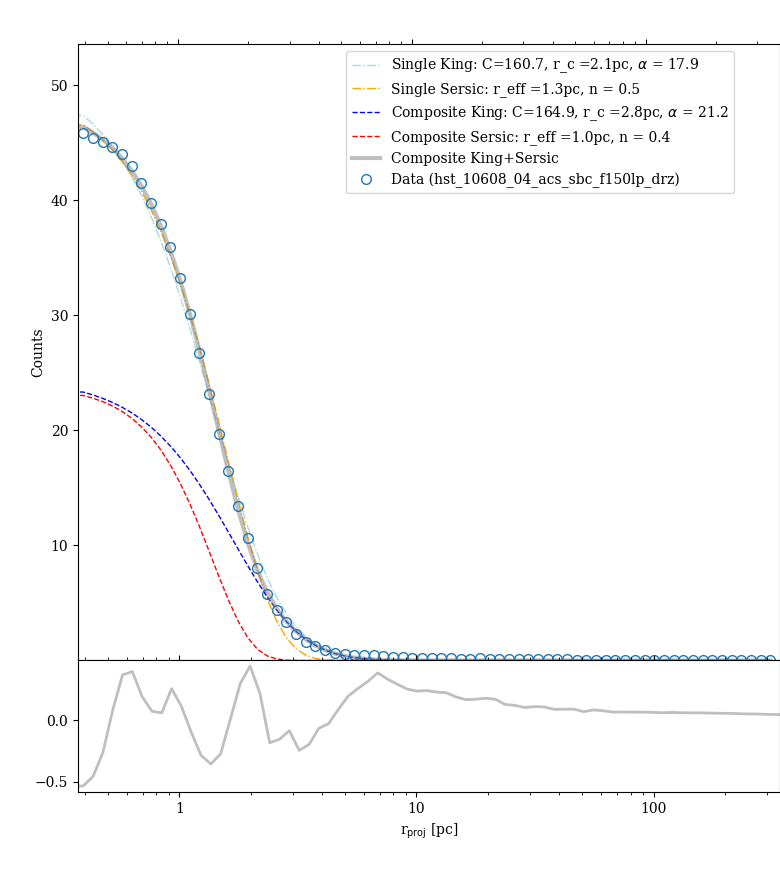

In [15]:
# Fit a 1D King, Sersic and King + Sersic profiles for initial evaluation 
from astropy.modeling.models import custom_model
from astropy.modeling import functional_models

#x = temp['sma']*pix_to_pc
#y = temp['intens']
x = isolist.sma*pix_to_pc
y = isolist.intens

# Define model
@custom_model
def ModifiedKing(r,I0 = 30,C=120.,r_c = 1.,alpha = 2.):
#    alpha=2.0
    return I0*( ( 1. - 1./((1+C**2.)**(1/alpha)) )**(-alpha) ) * ( (1/(((1+(r/r_c)**2.)**(1/alpha)) ) - 1/((1+C**2.)**(1/alpha)) )**alpha )

I0_init = y.max()
C_init = 500.
r_c_init = 2.*pix_to_pc
alpha_init = 2.0

# Fit model to data
m_init = ModifiedKing(I0 = I0_init,C=C_init,r_c = r_c_init,alpha = alpha_init)
s_init = functional_models.Sersic1D(amplitude=y.max()*.8, r_eff=5.9196199*pix_to_pc, n=.492617)
fit = LevMarLSQFitter()
m = fit(m_init, x, y)
s = fit(s_init, x, y)

m_init = ModifiedKing(I0 = m.I0.value/2.,C=m.C.value,r_c = m.r_c.value,alpha = m.alpha.value)
s_init = functional_models.Sersic1D(amplitude=s.amplitude.value/6., r_eff=s.r_eff.value, n=s.n.value)
k_s_init = m_init+s_init
fitter = fitting.SLSQPLSQFitter()
k_s = fitter(k_s_init, x, y)

m2 = ModifiedKing(I0=k_s.I0_0.value, C=k_s.C_0.value, r_c=k_s.r_c_0.value, alpha=k_s.alpha_0.value)
s2 = functional_models.Sersic1D(amplitude=k_s.amplitude_1.value, r_eff=k_s.r_eff_1.value, n=k_s.n_1.value)

print(k_s)

# Plot the data and the best fit
fig4 = plt.figure(4,figsize=(7.8,8.8))
fig4_ax = fig4.add_axes([0.1,0.25,.9,.7])
fig4_ax2 = fig4.add_axes([0.1,0.1,.9,.15])

fig4_ax.set_xscale('log')
fig4_ax.set_ylabel(r'Counts')
fig4_ax.plot(x, m(x),'-.',color='lightblue',linewidth=1,label=r'Single King: C={:.1f}, r_c ={:.1f}pc, $\alpha$ = {:.1f}'.format(m.C.value,m.r_c.value,m.alpha.value))
fig4_ax.plot(x, s(x),'-.',color='orange',linewidth=1,label='Single Sersic: r_eff ={:.1f}pc, n = {:.1f}'.format(s.r_eff.value,s.n.value))
fig4_ax.plot(x, m2(x),'--',color='blue',linewidth=1,label=r'Composite King: C={:.1f}, r_c ={:.1f}pc, $\alpha$ = {:.1f}'.format(m2.C.value,m2.r_c.value,m2.alpha.value))
fig4_ax.plot(x, s2(x),'--',color='red',linewidth=1,label='Composite Sersic: r_eff ={:.1f}pc, n = {:.1f}'.format(s2.r_eff.value,s2.n.value))
fig4_ax.plot(x, k_s(x),color='gray',linewidth=3,alpha=.5,label='Composite King+Sersic')
fig4_ax.plot(x, y, 'o',ms=7,fillstyle='none',label='Data ({:s})'.format(filename))
fig4_ax.set_xlim(x[1].min()*.95,x.max()*1.1)
fig4_ax.set_ylim(y.min()*.9,y.max()*1.1)

fig4_ax2.set_xscale('log'); fig4_ax2.set_xticks((.1,1,10,100)); fig4_ax2.set_xticklabels(['.1','1','10','100'])
fig4_ax2.set_xlim(x[1].min()*.95,x.max())
fig4_ax2.set_xlabel(r'r$_{\rm proj}$ [pc]')
fig4_ax2.plot(x, y-k_s(x),color='gray',linewidth=2,alpha=.5)
fig4.legend(bbox_to_anchor=(.95,.95))

In [16]:
# Save the figure 
fig4.savefig('{:s}_{:s}_x{:s}_y{:s}_pyell_1Dfit.pdf'.format(target,filename,str(g.x0),str(g.y0)),\
            format='pdf',transparent=True,dpi=250) #,bbox_inches='tight')
print('Saved figure {:s}_{:s}_x{:s}_y{:s}_pyell_1Dfit.pdf'.format(target,filename,str(g.x0),str(g.y0)))

Saved figure dw1335_29_hst_10608_04_acs_sbc_f150lp_drz_x695.0_y719.0_pyell_1Dfit.pdf


In [17]:
%run ~/Work/Scripts/reff_calc.py


Estimating the effective projected radius of a modified King'62 model
for the following core radius, rc, concentration, rt/rc=C and alpha:

Enter concentration, C =  rt/rc : 100
Enter King alpha : 2
Enter core radius rc : 2
rc = 2.00, rt/rc = C = 100.00, alpha = 2.00

r_eff = 10.30
